
* With the current setup
    * Get the yearly mean for our rough estimate

    * Get the weighted areas, to get energy per grid box




* Can we satisfy the instantaneus demand?
    * Get the instantaneus max demand in a year (Najme)

* Where to put the solar panels?
   * Which are the areas of higher contribution (Selma's cool algorithm)
       * Use top 30 boxes for the local maxima ie, 30 boxes with highest pvpot (mean pvpot or sum pvpot)
   * What makes a place a good place to put solar panels? (Najme)
       *  Radiation, temperature and wind are already accounted in pvpot
       *  ?
       *  Are mountains a good place?
       *  Populated areas?
       *  Beach front
       *  Natural reserves (parks)
       *  Ocean or sea ? can we put them in the mediterranian

* Problem for the future:
    * Max pvpot is at mid day, max consumption is in the evenening
       * What is the maximum difference?
       * How much energy should be stored or commerced(import export)?

In [2]:
%load_ext autoreload
%autoreload
import tools as tools
import core as core

In [26]:
# Open dataset and filter for europe
# range=> [) is open on the right side so +1 to remember
ds = tools.open_dataset(months=range(1,12+1))
ds_eu = tools.filter_europe_box(ds)

# Filter for Iran
# ds_eu = ds.sel(latitude=slice(40, 24)).sel(longitude=slice(40, 62))

In [20]:
ds_eu

<xarray.Dataset> Size: 405MB
Dimensions:     (valid_time: 744, latitude: 141, longitude: 161)
Coordinates:
    number      int64 8B ...
  * valid_time  (valid_time) datetime64[ns] 6kB 2000-01-01 ... 2000-01-31T23:...
  * latitude    (latitude) float64 1kB 70.0 69.75 69.5 69.25 ... 35.5 35.25 35.0
  * longitude   (longitude) float64 1kB -10.0 -9.75 -9.5 ... 29.5 29.75 30.0
    expver      (valid_time) <U4 12kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables:
    t2m         (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrd        (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    ssrdc       (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    u10         (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    v10         (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
    wspd        (valid_time, latitude, longitude) float32 68MB dask.array<chunksize=(744, 41, 40), meta=np.ndarray>
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-21T19:50 GRIB to CDM+CF via cfgrib-0.9.1...

In [29]:
# Lets do a rough estimate calculating the overall mean
pvpot_pre = core.pv_pot(ds_eu).groupby(ds_eu.valid_time.dt.month).mean(dim=("valid_time","latitude","longitude"))

In [30]:
# Do the proper computation
pvpot = tools.dask_compute(pvpot_pre, workers=5, threads=2)

<Client: 'tcp://127.0.0.1:33859' processes=5 threads=10, memory=753.83 GiB>
Execution time: 25.45687 seconds


In [31]:
pvpot.values

array([0.04707821, 0.07786103, 0.13314854, 0.18694378, 0.23292613,
       0.24583708, 0.22280404, 0.19147107, 0.13748726, 0.08209264,
       0.04819918, 0.03547181], dtype=float32)

In [7]:
print(f"Each square meter can produce a max of {pvpot.values*237} Watts in January")

Each square meter can produce a max of [11.157536] Watts in January


In [8]:
import pint
from pint import UnitRegistry
ureg = UnitRegistry()

# Doing a naive calculation of europe

#AREA:
area_europe = 10.53e6 * (ureg.kilometer * ureg.kilometer)
# '#' compact '~' short 'P' Pretty
print(f"Area Europe: {area_europe:#P}")

# Panel rate for panels ---
panel_rated_ouput = 237 * ureg.watt / (ureg.meter * ureg.meter)
print(f"Panel Rated Output: {panel_rated_ouput:#~P}")

europe_max_solar_energy = pvpot.values.item() * panel_rated_ouput * area_europe
print(f"Max solar energy production europe: {europe_max_solar_energy:#~P.2f}")


europe_max_solar_energy_month = europe_max_solar_energy * (720 * ureg.hour)
print(f"Max solar energy production europe month Wh: {europe_max_solar_energy_month:#~P.2f}")
print(f"Max solar energy production europe month J: {europe_max_solar_energy_month.to('joule'):#P.2f}")


Area Europe: 10.53 megameter²
Panel Rated Output: 237.0 W/m²
Max solar energy production europe: 117.49 TW
Max solar energy production europe month Wh: 84.59 PW·h
Max solar energy production europe month J: 304.53 exajoule


In [9]:
area_europe

10530000.0 <Unit('kilometer ** 2')>

In [20]:
# https://ec.europa.eu/eurostat/databrowser/view/nrg_cb_e__custom_13932565/default/table?lang=en
europe_electricity_consumption = 2824313.722 * 10e9 * ureg.Wh
print(f"{europe_electricity_consumption.to('gigawatthour'):_}")
print(f"{europe_electricity_consumption.to('gigawatthour'):#~P}")

28_243_137.220000003 gigawatt_hour
28.24313722 PWh


In [21]:
 europe_electricity_consumption / europe_max_solar_energy_month 

333874.9013344226 <Unit('meter ** 2 * watt_hour / hour / kilometer ** 2 / watt')>

In [23]:
84.59/28.2

2.9996453900709223

In [25]:
(28.2/12)/84.59

0.027781061591204633

In [49]:
area_europe_km2 = 10.53e6 # * ureg.meter * ureg.meter # km2
area_europe_m2 = area_europe_km2 * 1e6

# Panel rate for panels ---
panel_rated_ouput_per_m2 = 237

europe_watts_per_m2 = pvpot * panel_rated_ouput_per_m2
europe_watts = europe_watts_per_m2 * area_europe_m2
# europe_watts_hour = europe_watts * 3600

In [50]:
europe_watts_computed = europe_watts.compute()
europe_watts_val = europe_watts_computed.values.item()

/headless/envs/magic/lib/python3.10/site-packages/xarray/core/variable.py:306: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


In [52]:
print(f"Europe can produce {europe_watts_val:.3e} W")

Europe can produce 1.175e+14 W


In [55]:
print(f"Europe can produce {europe_watts_val/1e12:.3f} TW")

Europe can produce 117.489 TW


In [74]:
# To get the number of jules multiply by the seconds in a month
europe_joules_month = europe_watts_val * 3600 * 24 * 30

In [75]:
print(f"Europe can produce {europe_joules_month:.3e} Jules in a month")

Europe can produce 3.045e+20 Jules in a month


In [76]:
print(f"Europe could have produced {europe_joules_month/1e18:.3f} Exa Jules",
      "in the month of January of 2000 if was fully covered with solar panels")

Europe could have produced 304.531 Exa Jules in the month of January of 2000 if was fully covered with solar panels


In [61]:
import pint

In [3]:
# Main pvpot calculation and grouping
pvpot_pre = core.pv_pot(ds_eu).groupby(ds_eu.valid_time.dt.month).sum("valid_time")
# Overal mean

In [4]:
# Multiplying by rateHeat
panel_rated_ouput_per_m2 = 237
# Rate times 3600 to have watts to watts hour, divide over 1e6 to get mega watts hour
energy_month = pvpot_pre * panel_rated_ouput_per_m2 * 3600 / 1_000_000

# For area per box 
# a b = pi a dlat/180 dlat:1/4
# dx = 2 pi a dlon/360  cos theta
# Area = dy dx const const cos(theta)


In [5]:
# Do the proper computation
pvpot = tools.dask_compute(energy_month)

Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x7efc8c5838e0>>
Traceback (most recent call last):
  File "/headless/envs/magic/lib/python3.10/site-packages/distributed/utils_perf.py", line 179, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt: 
Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x7fcce17d78e0>>
Traceback (most recent call last):
  File "/headless/envs/magic/lib/python3.10/site-packages/distributed/utils_perf.py", line 179, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterrupt: 
Exception ignored in: <bound method GCDiagnosis._gc_callback of <distributed.utils_perf.GCDiagnosis object at 0x7f4fdeb078e0>>
Traceback (most recent call last):
  File "/headless/envs/magic/lib/python3.10/site-packages/distributed/utils_perf.py", line 179, in _gc_callback
    def _gc_callback(self, phase, info):
KeyboardInterru

KeyboardInterrupt: 

In [43]:
tools.print_pvpot_stats(pvpot)

Calculated pvpot:
    Shape: (12, 141, 161)
    Months: 12
    Min: 0.0
    Mean: 85.50216139585734
    Max: 200.433008
    Std: 53.33090058174218
    


In [10]:
import matplotlib.pyplot as plt

Text(0.5, 0.98, 'MegaWatts Hour per month per m^2')

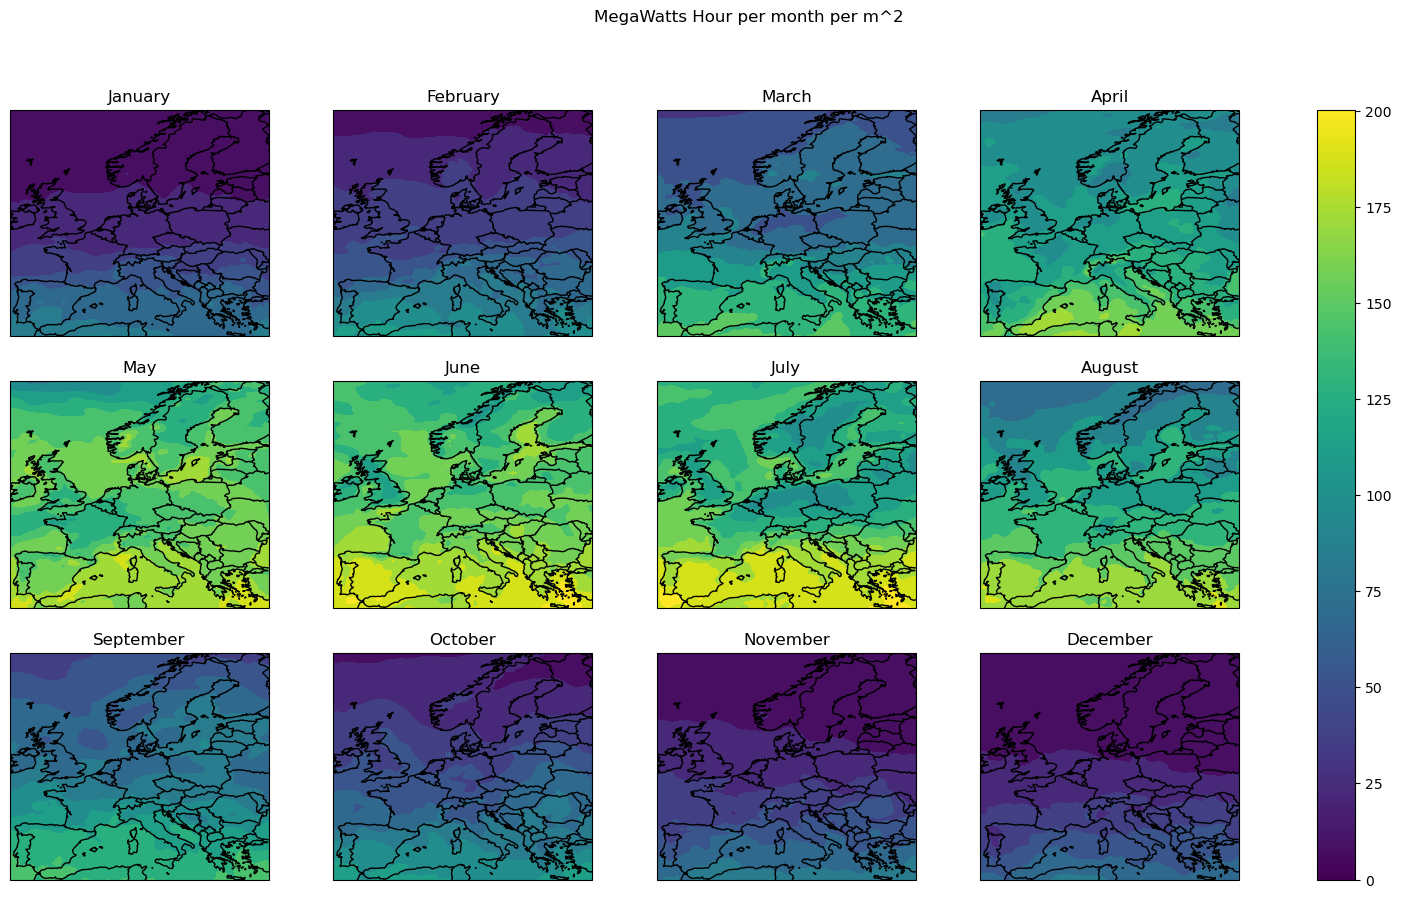

In [45]:
fg, ax = tools.plot_pvpot_per_month(pvpot, 0, pvpot.max())
fg.suptitle("MegaWatts Hour per month per m^2")